# Übung 7 - Recurrent Neural Networks

In dieser Übung wirst du ein RNN mittels Keras selbst erstellen und trainieren.

Das RNN soll Zeichenketten der Form `123+654` Zeichen für Zeichen one-hot kodiert als Eingabe erhalten und anschließend das Ergebnis der beschriebenen Rechnung zeichenweise ausgeben.
Es handelt sich hierbei also um *sequence to sequence learning*, da wir aus einer Eingabesequenz anschließend eine Ausgabesequenz erzeugen.

Die Trainingsdaten, auf denen wir das Netz trainieren, können wir selbst erzeugen.

In [1]:
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, SimpleRNN, RepeatVector, TimeDistributed, Dense, Input, Lambda
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
DIGITS = 3

## One-hot encoding

Zunächst benötigen wir eine Klasse, welche die one-hot Kodierung und Dekodierung übernimmt.

**Aufgabe**: Implementiere eine Klasse, welche zu Kodierung und Dekodierung der Eingabesequenzen verwendet werden kann. Diese soll folgende Funktionalitäten bieten:
* Übergabe das Alphabets als Zeichenkette bei der Objekterzeugung
* Kodierung eines Strings: Umwandlung eines Strings in eine Matrix, welche die Vektoren aus der one-hot kodierten Eingabe enthält. Zusätzlich soll eine Länge `length` angegeben werden, bis zu welcher Länge die Zeichenkette mit Leerzeichen aufgefüllt wird.
    * Dimensionen der entstehenden Matrix: `(length, alphabet_length)`
    * **Hinweis**: Dieses Auffüllen der Sequenz mit Leerzeichen erleichtert uns später die Erstellung des Modells. Natürlich eignen sich RNNs auch dazu Sequenzen unterschiedlicher Länge als Eingabe einzulesen, was diesen Schritt in anderen Fällen obsolet macht.
* Dekodierung eines Vektors. Als Eingabe erhält die Funktionen einen Vektor mit den Wahrscheinlichkeiten der Auswahl der Zeichen, also einen Vektor mit `alphabet_length` Einträgen. Hier reicht es aus das Zeichen, welches mit höchster Wahrscheinlichkeit ausgewählt wird, zu ermitteln und zurückzugeben.

In [3]:
class OneHot(object):
    def __init__(self, characters):
        self.chars = sorted(set(characters))
        self.char_to_index = dict((char, i) for i, char in enumerate(self.chars))
        self.index_to_char = dict((i, char) for i, char in enumerate(self.chars))

    def encode(self, string, length):
        enc = np.zeros((length, len(self.chars)))
        for i, char in enumerate(string):
            enc[i, self.char_to_index[char]] = 1
        for i in range(len(string), length):
            enc[i, self.char_to_index[' ']] = 1
        return enc
    
    def decode_max(self, vec):
        return self.index_to_char[np.argmax(vec)]

## Erzeugung der Trainingsdaten

Zum Training des Netzes benötigen wir Trainingsdaten, welche wir uns in ausreichender Menge selbst erstellen können.

**Aufgabe**: Erstelle eine Funktion, welche Trainingsdaten einer bestimmten Größe für unsere Problemstellung erzeugt.
* Per Parameter kann diese eine Anzahl Ziffern übergeben bekommen, aus denen eine Zahl maximal bestehen darf.
* Beachte dabei: Diese Funktion gibt Zeichenketten, keine `integer` zurück
* Es sollte keine Aufgabe mehrfach in den Daten vorkommen

In [4]:
def create_data_add(size, digits=DIGITS):
    X = []
    y = []
    hist = []
    while len(X) < size:
        num1 = np.random.randint(low=0, high=10 ** digits - 1)
        num2 = np.random.randint(low=0, high=10 ** digits - 1)
        if not (num1, num2) in hist:
            hist.append((num1, num2))
            X.append('{}+{}'.format(num1, num2))
            y.append(str(num1 + num2))
    return X, y

**Aufgabe**: Erzeuge einen Datensatz mit 50000 Einträgen, welchen wir für das Training benutzen und erzeuge die One-Hot kodierte Matrix dieses Datensatzes.
Teile diesen anschließend in 20% Validierungs- und 80% Trainingsdatensatz ein.

In [5]:
X, y = create_data_add(50000)

encoder = OneHot('0123456789+ ')
for i in range(len(X)):
    X[i] = encoder.encode(X[i], 3 * 2 + 1)
    y[i] = encoder.encode(y[i], 4)

In [6]:
X = np.array(X)
y = np.array(y)
X_train, X_val = X[:40000], X[40000:]
y_train, y_val = y[:40000], y[40000:]

## Modell

Zur Lösung unseres Problems benötigen wir ein Sequence-to-Sequence Modell, also ein Modell, welches zunächst elementweise eine Eingabesequenz erhält und anschließend, ebenfalls elementweise, eine Ausgabesequenz ausgibt.
Das Einlesen geschieht im Encoder (im Bild weiß), das anschließende Auswerten des sich ergebenden Zellzustandes im Decoder (grau), welche beide RNN-Zellen sind.
Wir verwenden hier zunächst LSTM-Zellen.

![Sequence to Sequence Modell](seq2seq.png)

Wir bauen dieses Modell wie folgt mit Hilfe von `Sequential` in Keras auf.


In [7]:
HIDDEN_SIZE = 256
EPOCHS = 50
ALPHABET_LENGTH = len('0123456789+ ')
MAXLEN = DIGITS * 2 + 1

In [8]:
model = Sequential()
model.add(LSTM(HIDDEN_SIZE, input_shape=(MAXLEN, ALPHABET_LENGTH))) # Encoder
model.add(RepeatVector(DIGITS + 1))  # Stellt dem RNN im nächsten Schritt die Ausgabe des vorherigen bereit
model.add(LSTM(HIDDEN_SIZE, return_sequences=True)) # Decoder
model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax'))) # Wendet eine `Dense` Schicht auf jede Ausgabe des Decoders an
                                # und ermittelt mittels 'softmax'-Funktion die Auswahlwahrscheinlichkeiten der Zeichen
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               275456    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             3084      
Total params: 803,852
Trainable params: 803,852
Non-trainable params: 0
_________________________________________________________________


## Training

**Aufgaben**: Trainiere das oben erstellte Netz für 50 Epochen. Denke daran einen Teil der Daten zur Validation zu verwenden.
* Implementiere die untenstehende Funktion `train`
* Um den Trainingsfortschritt zu beobachten soll nach jeder fünften Epoche eine Ausgabe erzeugt werden, in der zehn Einträge des **Valisierungs**datensatzes und die vom neuronalen Netz erzeugten Ausgabesequenzen visualisiert werden. Hierbei sollte auch sichtbar sein, ob die Ausgabe des Netzes korrekt war. Wer möchte kann dazu die untenstehende Klasse `colors` verwenden, um mit ANSI color codes die Ausgabe einzufärben.
* Führe `train` aus. Plotte den Verlauf von `loss` und `accuracy`, sowohl auf dem Trainings- als auch auf dem Validierungsset.

In [9]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [10]:
def train(model, X_train, y_train, X_val, y_val, encoder, epochs):
    loss, acc, val_loss, val_acc = [], [], [], []
    for iteration in range(1, epochs + 1):
        print('-' * 50)
        print('Iteration', iteration)
        hist = model.fit(X_train, y_train,
                  batch_size=1000,
                  epochs=1,
                  validation_data=(X_val, y_val))
        loss.append(hist.history['loss'])
        acc.append(hist.history['acc'])
        val_loss.append(hist.history['val_loss'])
        val_acc.append(hist.history['val_acc'])
        if iteration % 5 == 0:
            for i in range(10):
                ind = np.random.randint(0, X_val.shape[0])
                rowx, rowy = X_val[ind], y_val[ind]
                strx = ''
                for seqx in rowx:
                    strx += encoder.decode_max(seqx)
                stry = ''
                for seqy in rowy:
                    stry += encoder.decode_max(seqy)
                preds = model.predict_classes([[rowx]], verbose=0)
                strpred = ''
                for p in preds[0]:
                    strpred += encoder.index_to_char[p]
                if stry.strip() == strpred.strip():
                    print('{}{} = {} ☑ {}{}'.format(colors.ok, strx, stry, strpred, colors.close))
                else:
                    print('{}{} = {} ☒ {}{}'.format(colors.fail, strx, stry, strpred, colors.close))
    return loss, acc, val_loss, val_acc

In [11]:
loss, acc, val_loss, val_acc = train(model, X_train, y_train, X_val, y_val, encoder, EPOCHS)

--------------------------------------------------
Iteration 1
Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 9s 228us/step - loss: 2.2209 - acc: 0.2857 - val_loss: 1.9888 - val_acc: 0.3135
--------------------------------------------------
Iteration 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 1.9554 - acc: 0.3152 - val_loss: 1.9250 - val_acc: 0.3139
--------------------------------------------------
Iteration 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 1.9142 - acc: 0.3161 - val_loss: 1.8988 - val_acc: 0.3139
--------------------------------------------------
Iteration 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 1.8794 - a

40000/40000 [==============================] - 8s 195us/step - loss: 0.8741 - acc: 0.7039 - val_loss: 0.8354 - val_acc: 0.7141
--------------------------------------------------
Iteration 27
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 0.8032 - acc: 0.7316 - val_loss: 0.7556 - val_acc: 0.7578
--------------------------------------------------
Iteration 28
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 0.7353 - acc: 0.7641 - val_loss: 0.7149 - val_acc: 0.7497
--------------------------------------------------
Iteration 29
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 0.6865 - acc: 0.7826 - val_loss: 0.6644 - val_acc: 0.7862
--------------------------------------------------
Iteration 30
Train on 40000 samples, validate on 10000 samples
Epoch 

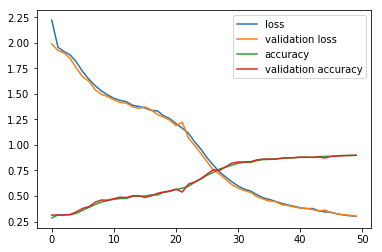

In [12]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='validation loss')
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.show()

## Subtraktion statt Addition

**Aufgabe**: Wir werden nun das oben stehende Netz auf Subtraktion statt Addition trainieren.
Implementiere dazu eine Funktion oder ändere die obenstehende ab, um entsprechende Trainingsdaten zu erzeugen.

In [13]:
def create_data_sub(size, digits=3):
    X = []
    y = []
    hist = []
    while len(X) < size:
        num1 = np.random.randint(low=0, high=10 ** digits - 1)
        num2 = np.random.randint(low=0, high=10 ** digits - 1)
        if not (num1, num2) in hist:
            hist.append((num1, num2))
            X.append('{}-{}'.format(num1, num2))
            y.append(str(num1 - num2))
    return X, y

**Aufgabe**: Erzeuge wie oben einen Datensatz und One-Hot-Kodiere ihn.

In [14]:
X, y = create_data_sub(50000)

encoder_sub = OneHot('0123456789- ')
for i in range(len(X)):
    X[i] = encoder_sub.encode(X[i], 3 * 2 + 1)
    y[i] = encoder_sub.encode(y[i], 4)
    
X = np.array(X)
y = np.array(y)
X_train_sub, X_val_sub = X[:40000], X[40000:]
y_train_sub, y_val_sub = y[:40000], y[40000:]

**Aufgabe**: Trainiere sowohl ein "frisches", untrainiertes Netz so wie eine Kopie des zuvor auf die Addition trainierten Netzes wie oben beschrieben und vergleiche den Trainingserfolg. Was fällt auf?

In [15]:
sub_model = Sequential()
sub_model.add(LSTM(HIDDEN_SIZE, input_shape=(MAXLEN, ALPHABET_LENGTH))) # Encoder
sub_model.add(RepeatVector(DIGITS + 1))
sub_model.add(LSTM(HIDDEN_SIZE, return_sequences=True)) # Decoder
sub_model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax')))
sub_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

plus_model = Sequential.from_config(model.get_config())
plus_model.set_weights(model.get_weights())
plus_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

pre_loss, pre_acc, pre_val_loss, pre_val_acc = train(plus_model, X_train_sub, y_train_sub, X_val_sub, y_val_sub, encoder_sub, EPOCHS)
new_loss, new_acc, new_val_loss, new_val_acc = train(sub_model, X_train_sub, y_train_sub, X_val_sub, y_val_sub, encoder_sub, EPOCHS)

--------------------------------------------------
Iteration 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 9s 232us/step - loss: 3.1734 - acc: 0.2148 - val_loss: 2.1338 - val_acc: 0.2430
--------------------------------------------------
Iteration 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 2.0324 - acc: 0.2945 - val_loss: 1.9388 - val_acc: 0.3370
--------------------------------------------------
Iteration 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 1.8689 - acc: 0.3472 - val_loss: 1.8130 - val_acc: 0.3584
--------------------------------------------------
Iteration 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 1.7493 - acc: 0.3727 - val_loss: 1.6905 - val_acc: 0.3920


40000/40000 [==============================] - 8s 195us/step - loss: 0.4317 - acc: 0.8669 - val_loss: 0.4410 - val_acc: 0.8563
--------------------------------------------------
Iteration 28
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 0.4155 - acc: 0.8720 - val_loss: 0.4256 - val_acc: 0.8608
--------------------------------------------------
Iteration 29
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 0.3983 - acc: 0.8782 - val_loss: 0.4098 - val_acc: 0.8688
--------------------------------------------------
Iteration 30
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 0.3847 - acc: 0.8819 - val_loss: 0.3995 - val_acc: 0.8707
529-154 = 375  ☑ 375 
811-881 = -70  ☑ -70 
803-41  = 762  ☒ 860 
736-475 = 261  ☑ 261 
757-410 = 347  ☑ 347 
370-250 = 

--------------------------------------------------
Iteration 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 1.8165 - acc: 0.3535 - val_loss: 1.7902 - val_acc: 0.3568
--------------------------------------------------
Iteration 5
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 194us/step - loss: 1.7515 - acc: 0.3755 - val_loss: 1.7118 - val_acc: 0.3892
593-567 = 26   ☒ 11  
574-761 = -187 ☒ -1  
137-16  = 121  ☒ 21  
33-353  = -320 ☒ -411
910-521 = 389  ☒ 316 
734-672 = 62   ☒ -1  
71-482  = -411 ☒ -489
448-474 = -26  ☒ -12 
461-347 = 114  ☒ 11  
629-97  = 532  ☒ -1  
--------------------------------------------------
Iteration 6
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 195us/step - loss: 1.6956 - acc: 0.3913 - val_loss: 1.6649 - val_acc: 0.3998
------------------------------

40000/40000 [==============================] - 8s 196us/step - loss: 1.2238 - acc: 0.5514 - val_loss: 1.2435 - val_acc: 0.5412
812-11  = 801  ☒ 709 
800-360 = 440  ☒ 400 
831-860 = -29  ☒ -2  
103-903 = -800 ☒ -797
878-81  = 797  ☒ 777 
135-364 = -229 ☒ -220
874-496 = 378  ☒ 489 
701-9   = 692  ☒ 747 
4-425   = -421 ☒ -444
939-114 = 825  ☒ 750 
--------------------------------------------------
Iteration 31
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 194us/step - loss: 1.2238 - acc: 0.5494 - val_loss: 1.2218 - val_acc: 0.5422
--------------------------------------------------
Iteration 32
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 8s 196us/step - loss: 1.2019 - acc: 0.5556 - val_loss: 1.2017 - val_acc: 0.5514
--------------------------------------------------
Iteration 33
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============

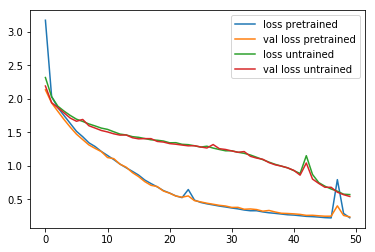

In [16]:
plt.plot(pre_loss, label='loss pretrained')
plt.plot(pre_val_loss, label='val loss pretrained')
plt.plot(new_loss, label='loss untrained')
plt.plot(new_val_loss, label='val loss untrained')
plt.legend()
plt.show()

## RNN, LSTM, GRU

**Aufgabe**: Ändere die zuvor verwendete Netzarchitektur so ab, dass anstelle von `LSTM`s `SimpleRNN`s oder `GRU`s verwendet werden, trainiere diese und vergleiche erneut den Lernerfolg. Was fällt auf?

In [17]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(MAXLEN, ALPHABET_LENGTH))) # Encoder
rnn_model.add(RepeatVector(DIGITS + 1))
rnn_model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True)) # Decoder
rnn_model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax')))
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_loss, rnn_acc, rnn_val_loss, rnn_val_acc = train(rnn_model, X_train, y_train, X_val, y_val, encoder, EPOCHS)

gru_model = Sequential()
gru_model.add(GRU(HIDDEN_SIZE, input_shape=(MAXLEN, ALPHABET_LENGTH))) # Encoder
gru_model.add(RepeatVector(DIGITS + 1))
gru_model.add(GRU(HIDDEN_SIZE, return_sequences=True)) # Decoder
gru_model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax')))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_loss, gru_acc, gru_val_loss, gru_val_acc = train(gru_model, X_train, y_train, X_val, y_val, encoder, EPOCHS)

--------------------------------------------------
Iteration 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 4s 90us/step - loss: 1.8812 - acc: 0.3197 - val_loss: 1.7457 - val_acc: 0.3524
--------------------------------------------------
Iteration 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 2s 60us/step - loss: 1.6964 - acc: 0.3757 - val_loss: 1.6499 - val_acc: 0.3991
--------------------------------------------------
Iteration 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 2s 59us/step - loss: 1.6077 - acc: 0.4155 - val_loss: 1.5558 - val_acc: 0.4275
--------------------------------------------------
Iteration 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 2s 59us/step - loss: 1.5094 - acc: 0.4573 - val_loss: 1.4601 - val_acc: 0.4727
----

40000/40000 [==============================] - 2s 59us/step - loss: 0.1685 - acc: 0.9569 - val_loss: 0.1882 - val_acc: 0.9454
--------------------------------------------------
Iteration 28
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 2s 60us/step - loss: 0.1701 - acc: 0.9536 - val_loss: 0.1873 - val_acc: 0.9446
--------------------------------------------------
Iteration 29
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 2s 59us/step - loss: 0.1599 - acc: 0.9576 - val_loss: 0.1820 - val_acc: 0.9448
--------------------------------------------------
Iteration 30
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 2s 59us/step - loss: 0.1518 - acc: 0.9597 - val_loss: 0.1677 - val_acc: 0.9513
883+80  = 963  ☒ 903 
501+322 = 823  ☑ 823 
859+421 = 1280 ☑ 1280
634+433 = 1067 ☑ 1067
194+208 = 402  ☒ 403 
773+332 = 1105

40000/40000 [==============================] - 6s 160us/step - loss: 1.8450 - acc: 0.3259 - val_loss: 1.7809 - val_acc: 0.3335
--------------------------------------------------
Iteration 5
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 6s 160us/step - loss: 1.6983 - acc: 0.3697 - val_loss: 1.6358 - val_acc: 0.4083
46+973  = 1019 ☒ 100 
149+134 = 283  ☒ 447 
441+670 = 1111 ☒ 1000
797+31  = 828  ☒ 807 
604+846 = 1450 ☒ 1400
501+332 = 833  ☒ 809 
555+688 = 1243 ☒ 1200
260+329 = 589  ☒ 677 
815+443 = 1258 ☒ 1200
941+152 = 1093 ☒ 1100
--------------------------------------------------
Iteration 6
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 6s 160us/step - loss: 1.5956 - acc: 0.4176 - val_loss: 1.5681 - val_acc: 0.4197
--------------------------------------------------
Iteration 7
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [=================

738+506 = 1244 ☒ 1245
782+809 = 1591 ☒ 1500
385+579 = 964  ☑ 964 
959+174 = 1133 ☒ 1123
731+767 = 1498 ☑ 1498
581+288 = 869  ☒ 848 
744+134 = 878  ☒ 886 
824+981 = 1805 ☒ 1802
410+662 = 1072 ☒ 1066
234+93  = 327  ☒ 410 
--------------------------------------------------
Iteration 31
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 6s 161us/step - loss: 0.9370 - acc: 0.6482 - val_loss: 0.8845 - val_acc: 0.6671
--------------------------------------------------
Iteration 32
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 6s 161us/step - loss: 0.8363 - acc: 0.6892 - val_loss: 0.7879 - val_acc: 0.7152
--------------------------------------------------
Iteration 33
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 6s 160us/step - loss: 0.7486 - acc: 0.7333 - val_loss: 0.7012 - val_acc: 0.7620
---------------------------

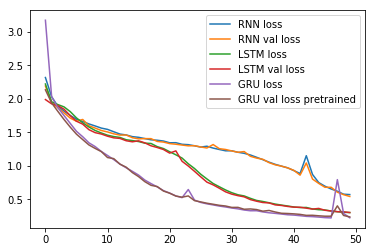

In [18]:
plt.plot(new_loss, label='RNN loss')
plt.plot(new_val_loss, label='RNN val loss')
plt.plot(loss, label='LSTM loss')
plt.plot(val_loss, label='LSTM val loss')
plt.plot(pre_loss, label='GRU loss')
plt.plot(pre_val_loss, label='GRU val loss pretrained')
plt.legend()
plt.show()